# MSB1015 Scientific programming
## Heart failure prediction model


During this project the goal is predicting heart failure in the Kaggle challenge heart failure prediction. The database contains 12 clinical features and 1 target. The features constitute several different data types forms integer numbers, percentages, and binarized data.


### Pre-Processing
The first step was loading in the data and a preliminary exploration.

In [1]:
## Data and module loading
# input: Tom_data.xlsx(external data file)
# output: df


# Importing neccesary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  #for this document to work needs to be seaborn 0.11 or higher

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import plotly
import plotly.graph_objs as go

from sklearn.ensemble import IsolationForest


# Loading in the heart failure data
df = pd.read_excel (r'Tom_data.xlsx')


# Preliminary data exploration
print(df.dtypes)
print(list(df.columns))
print(df.head())

age                         float64
anaemia                       int64
creatinine_phosphokinase    float64
diabetes                      int64
ejection_fraction           float64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                float64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object
['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time', 'DEATH_EVENT']
    age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                     582.0         0               20.0   
1  55.0        0                    7861.0         0               38.0   
2  65.0        0                     146.0         0               20.0   
3  50.0        1         

The data consists of 13 columns; Age, Anaemia, Creatine_phosphokinase, Diabetes, Ejection_fraction, High_blood_pressure, Platelets, Serum_creatine, Serum_sodium, Sex, smoking, Time, and Death event. The original publication and meta data from the challenge provider was used, in order to better grasp how these columns were obtained. Below a list containing both a description of how these parameters were obtained and the datatype they have are displayed.

1. Age
    - Age of the patient measured in years
    - interger data type
2. anaemia
    - Decrease of hemoglobin in the patient reported as status (0:False, 1:True)
    - binary data type
3. creatine phosphokinase
    - level of creatine phosphokinase in serum measured in mcg/L
    - integer data type
4. diabetes
    - Diabtetic status of the patient (0:False,1:True)
    - binary data type
5. ejection fraction
    - Percentage of blood leaving the heart on each contraction
    - fraction data type
6. high blood pressure
    - hypertension status of the patient (0:False,1:True)
    - binary datatype
7. platelets
    - Platelets in the blood measured in platelets/ml
    - integer datatype
8. serum creatine
    - creatine level in serum measured in mg/dL
    - integer datatype
9. serum sodium
    - sodium level in serum measured in mEq/l
    - integer datatype
10. sex
    - sex of the patient expressed as a binary (1:male,0:female)
    - binary datatype
11. smoking
    - smoking status of the patient (0:False,1:True)
    - binary datatype
12. time
    - follow up period till death (if death event is 1) or last contact (if death event is 0) measured in days
    - integer datatype
13. death event
    - death status during follow up period (0:False,1:True)
    - binary datatype
    
Further manual exploration of the data showed 3 logical discrepancies. The first was that in the age column several ages were expressed with decimal numbers. To correct for this the entire column was converted to integer data. The ejection fraction column has one negative value and an impossible high value which were both replaced with nan for future imputation. The same was done for the serum sodium variable which also had an impossible high variable.  

In [2]:
## changing logical inconsistencies in the dataframe
# input: df
# output: df

# convert the decimal numbers to interger numbers for the age column
df["age"] = df["age"].apply(np.int64)


#   ejection fraction has a negative value (-5) and a impossible high value (3.5e+06), these values are replaced with nan
df = df.replace(-5, np.nan)
df = df.replace(3.5e+06,np.nan)


#   serum_sodium has a impossible high value (2e+09), this is replaced with nan, there is also a 1 which is highly unlikely.
df = df.replace(2e+09,np.nan)
df["serum_sodium"] = df["serum_sodium"].replace(1,np.nan)

Visualization was done to further explore The variables. The data was converted, for this step, into seperate dataframes, in order to get the correct visualization per data type. 

C:\Users\tom\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


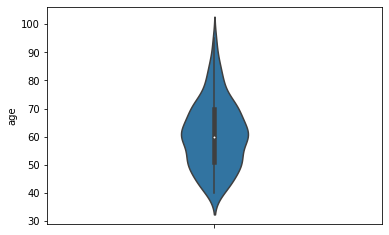

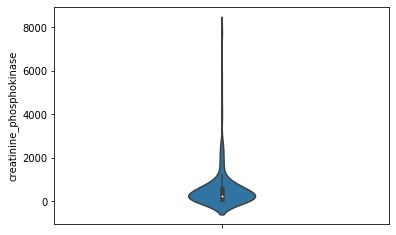

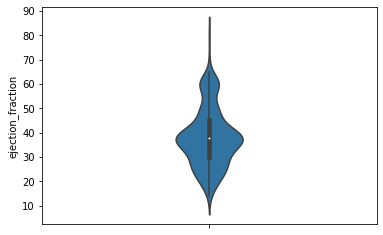

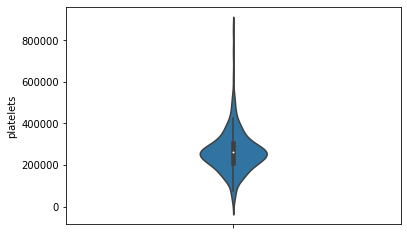

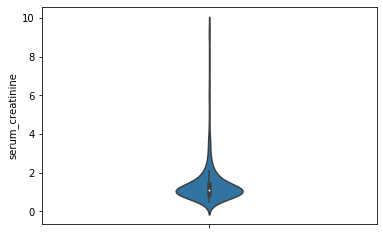

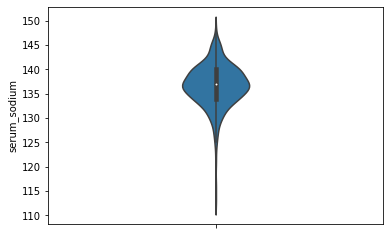

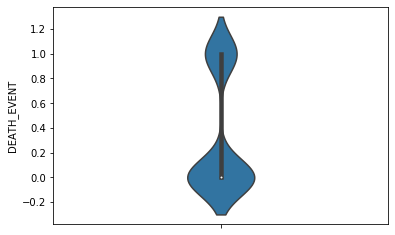

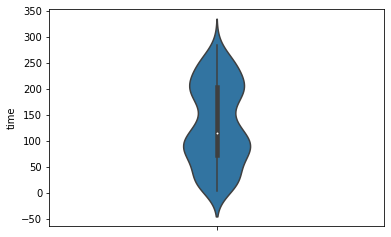

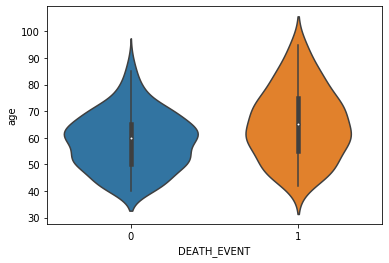

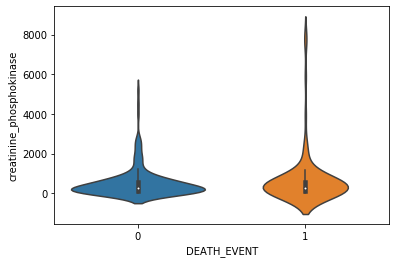

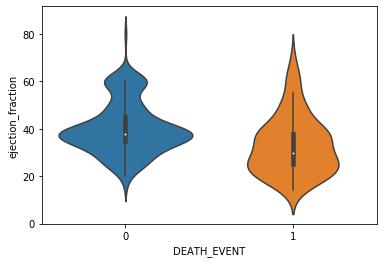

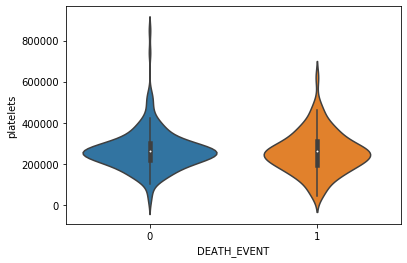

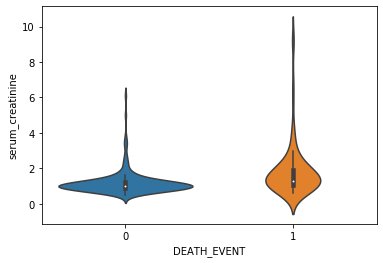

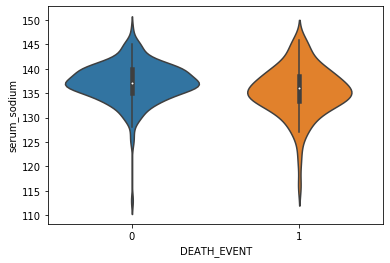

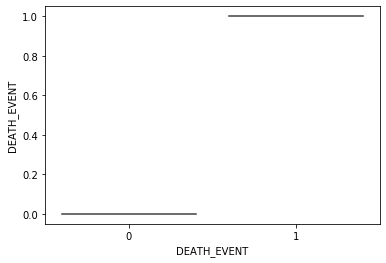

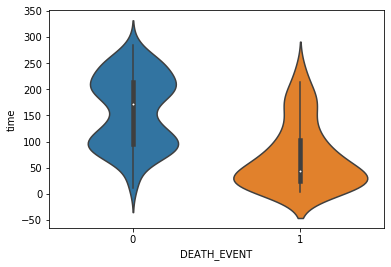

<Figure size 432x288 with 0 Axes>

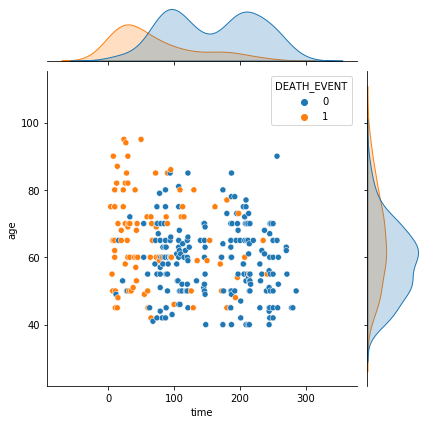

<Figure size 432x288 with 0 Axes>

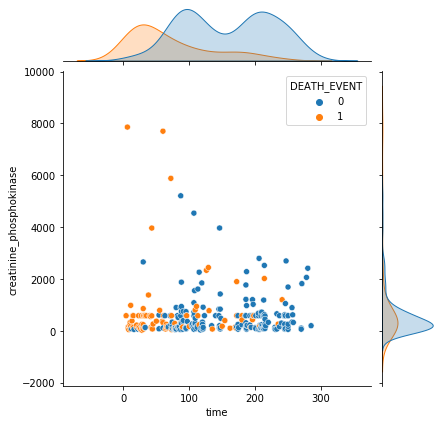

<Figure size 432x288 with 0 Axes>

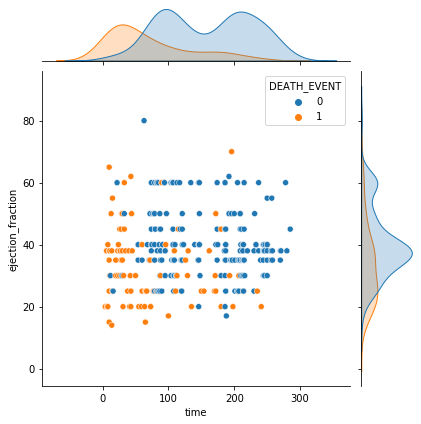

<Figure size 432x288 with 0 Axes>

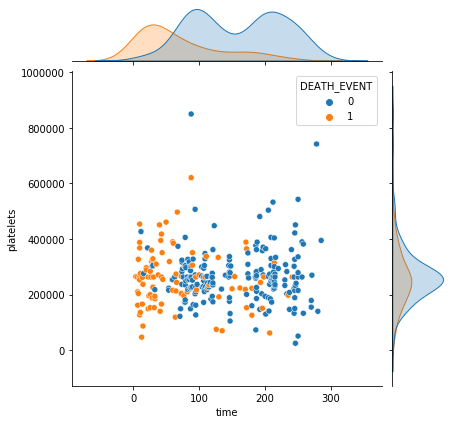

<Figure size 432x288 with 0 Axes>

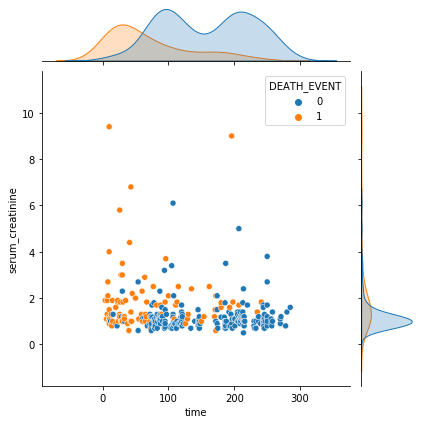

<Figure size 432x288 with 0 Axes>

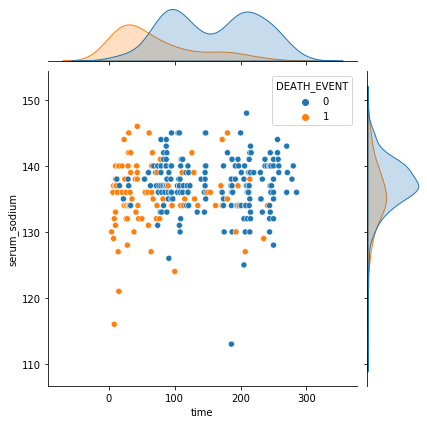

<Figure size 432x288 with 0 Axes>

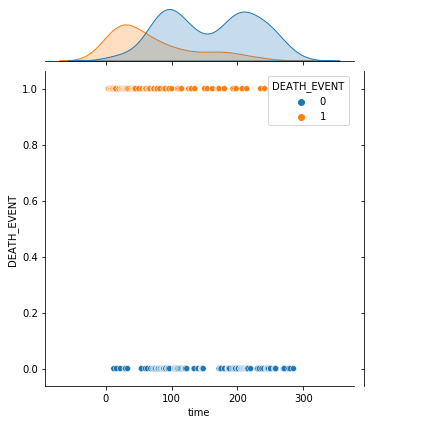

<Figure size 432x288 with 0 Axes>

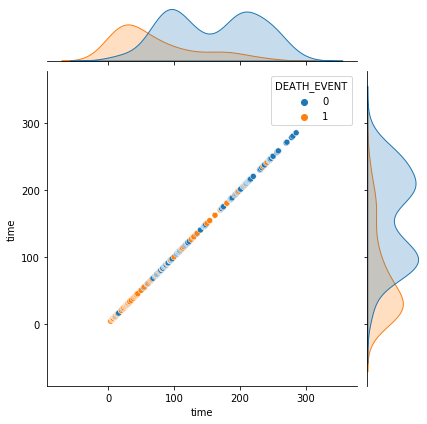

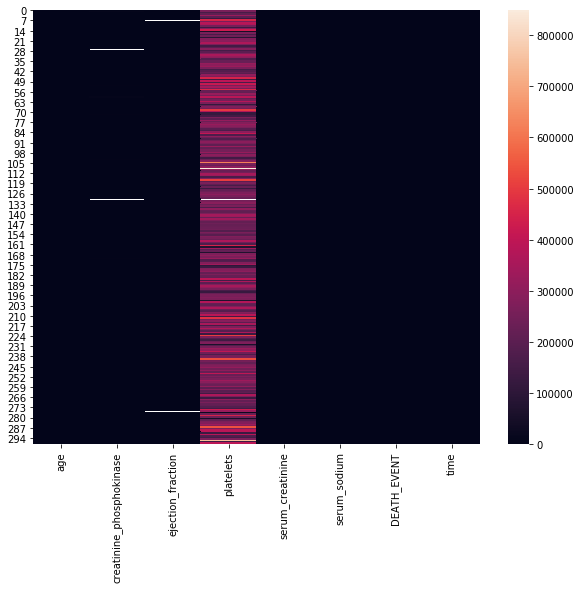

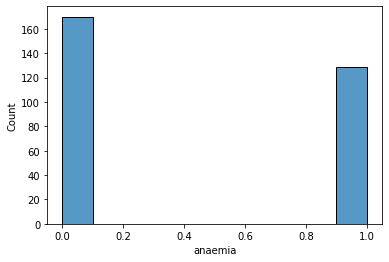

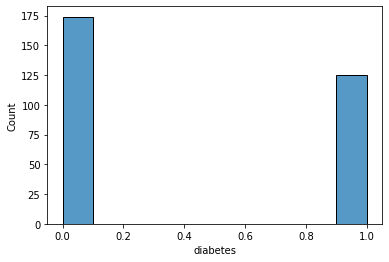

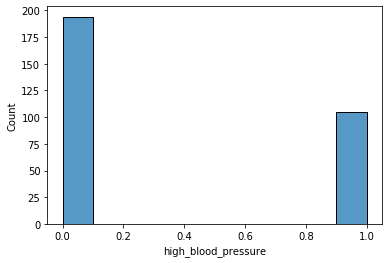

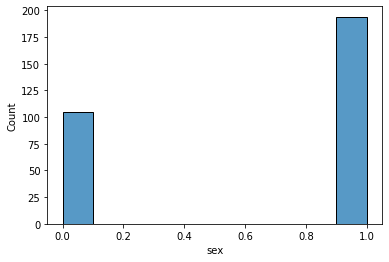

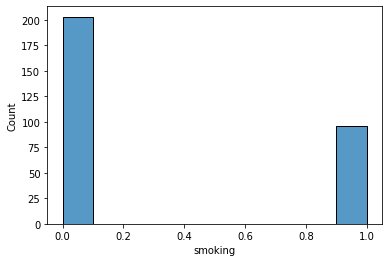

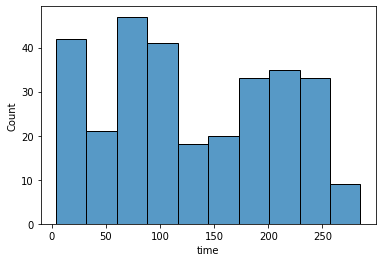

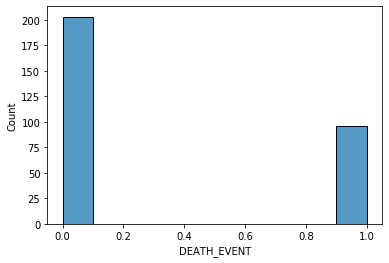

In [3]:
## pre-preprocess data exploration
# input: df
# output: df_binary (containing only binary variables, time, and death_event)
#         df_interger_fraction (Containing only interger, fractional, time, and death event)


# seperating the different data types into sub-data frames for the visualization
df_binary = df[['anaemia',
                'diabetes',
                'high_blood_pressure',
                'sex',
                'smoking',
                'time',
                'DEATH_EVENT']]

df_interger_fraction = df[['age',
                           'creatinine_phosphokinase',
                           'ejection_fraction',
                           'platelets',
                           'serum_creatinine',
                           'serum_sodium',
                           'DEATH_EVENT',
                           'time']]


# to not get memory warnings about the amount of plots
plt.rcParams.update({'figure.max_open_warning': 0})


# violin plot per variable, violin plot death per variable, and joint plot for the interger variable type
for column in df_interger_fraction :
    plt.figure()
    sns.violinplot(y=df_interger_fraction[column],width= 0.2)
  
for column in df_interger_fraction :
    plt.figure()
    sns.violinplot(x=df_interger_fraction ['DEATH_EVENT'], y=df_interger_fraction[column])
    
for column in df_interger_fraction :
    plt.figure()
    sns.jointplot(data=df_interger_fraction, x="time", y=column, hue="DEATH_EVENT")

    
# heatmap of the continouse data
plt.figure(figsize=(10,8))
sns.heatmap(df_interger_fraction)


# histogram plots for the binary 
for column in df_binary :
    plt.figure()
    sns.histplot(data=df_binary, x=column)
 

Due to the different data types normalization will not be performed, scaling will be performed. Scaling will be done using a min max scaler (0 to 1).

MinMaxScaler()


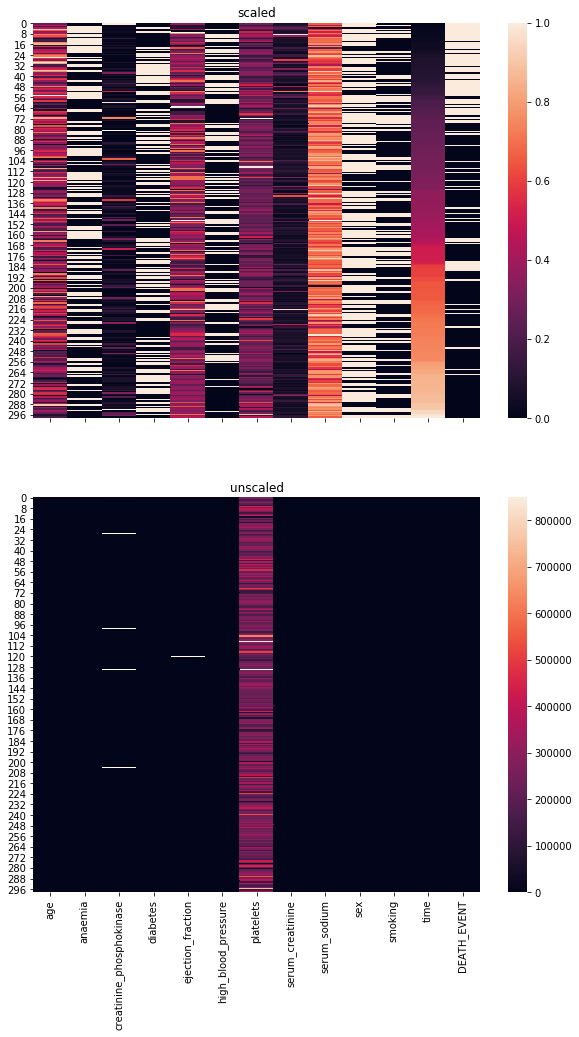

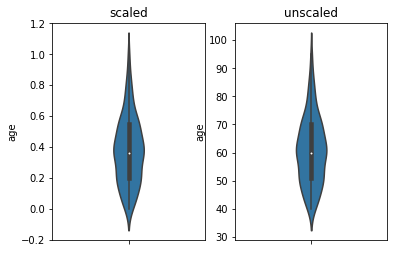

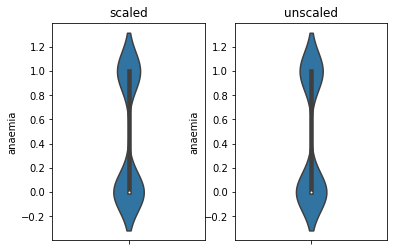

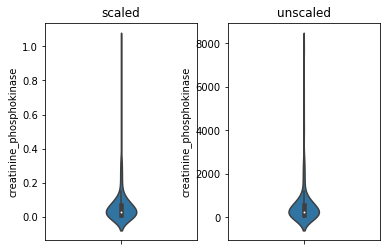

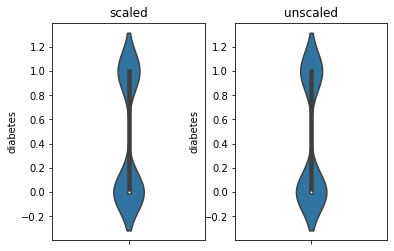

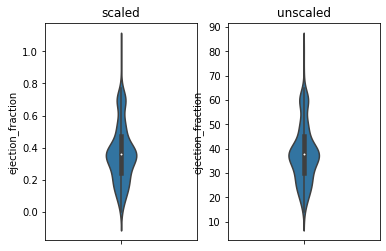

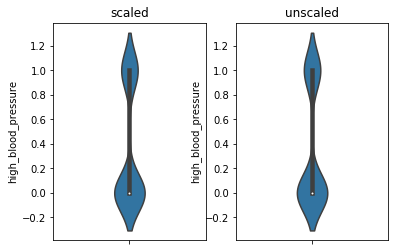

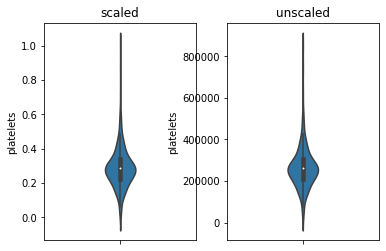

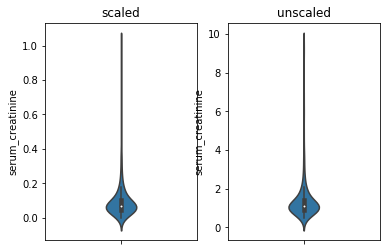

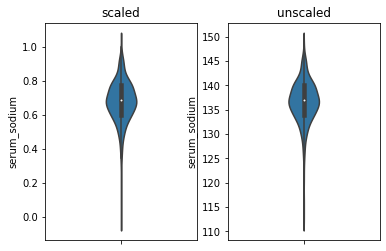

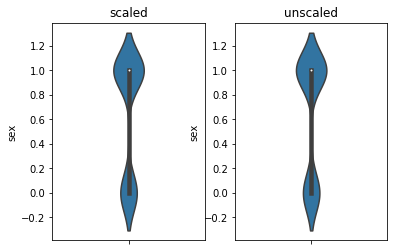

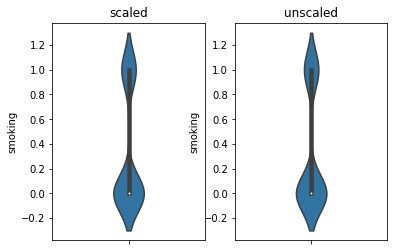

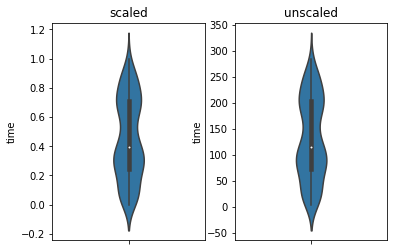

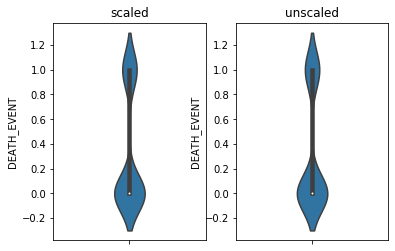

In [4]:
## data scaling 
# Input: df
# Output: df_scaled(data scaled per variable to a range between 0 and 1)

# scaling of the non binary variable collumns for distance based methods
scaler = MinMaxScaler()
print(scaler.fit(df))

# using the min max scaler and then converting the numpy array back to a pandas array
df_scaled = scaler.transform(df)
df_scaled = pd.DataFrame(data=df_scaled, columns=df.columns.tolist())



# heatmap comparison
fig,(ax1,ax2)= plt.subplots(nrows=2,figsize=(10,16),sharex=True)
sns.heatmap(df,ax=ax2).set_title("unscaled")
sns.heatmap(df_scaled,ax=ax1).set_title("scaled")


# violin plots to confirm scaling
for column in df_scaled :
       fig, (ax1, ax2) = plt.subplots(ncols=2)
       sns.violinplot(y=df_scaled[column],width= 0.2, ax=ax1).set_title("scaled")
       sns.violinplot(y=df[column],width= 0.2, ax=ax2).set_title("unscaled")
        

    

The scaling was succesful and did not significantly alter the distribution of the data that was present. The next step is the imputation of the nan values. The imputation will be done using a knn imputation method.

In [5]:
## imputation of scaled dataframe
# Input: df_scaled
# Output: df_scaled_imp_median (imputation using the median of a column)
#         df_scaled_imp_iterative (imputation using an iterative process)
#         df_scaled_knn1 (imputation using knn with n=1)
#         df_scaled_knn3 (imputation using knn with n=3)
#         df_scaled_knn5 (imputation using knn with n=5)


# function calculating the amount of misisng values in total, per column, per row, and
#   total amount of rows containg missing values 
# input: pandas dataframe
def imputation_stats(dataframe):
    missing_values_per_column = dataframe.isnull().sum()
    missing_values_total = dataframe.isnull().sum().sum()
    missing_values_per_row = []

    for i in range(len(dataframe.index)) :
        x = (dataframe.iloc[i].isnull().sum())
        missing_values_per_row.append(x)

    missing_values_per_row = np.array(missing_values_per_row)
    missing_values_in_rows = missing_values_per_row.sum()
    percentage_of_missing_values = (missing_values_in_rows/len(dataframe))*100

    # output results of missing values amount before imputation
    print('missing values:',missing_values_total)
    print('missing values per row:',missing_values_in_rows)
    print('missing values per row precentage',percentage_of_missing_values,'%')

    
# knn impuation of the missing values.

imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
imp_iterative = IterativeImputer(max_iter=10, random_state=42)
knn_1 = KNNImputer(n_neighbors=1)
knn_3 = KNNImputer(n_neighbors=3)
knn_5 = KNNImputer(n_neighbors=5)

df_scaled_imp_median = imp_median.fit_transform(df_scaled)
df_scaled_imp_iterative = imp_iterative.fit_transform(df_scaled)
df_scaled_knn1 = knn_1.fit_transform(df_scaled)
df_scaled_knn3 = knn_3.fit_transform(df_scaled)
df_scaled_knn5 = knn_5.fit_transform(df_scaled)

df_scaled_imp_median = pd.DataFrame(data=df_scaled_imp_median, columns=df.columns.tolist())
df_scaled_imp_iterative = pd.DataFrame(data=df_scaled_imp_iterative, columns=df.columns.tolist())
df_scaled_knn1 = pd.DataFrame(data=df_scaled_knn1, columns=df.columns.tolist())
df_scaled_knn3 = pd.DataFrame(data=df_scaled_knn3, columns=df.columns.tolist())
df_scaled_knn5 = pd.DataFrame(data=df_scaled_knn5, columns=df.columns.tolist())

#printing results of imputation
print('-----before imputation')
imputation_stats(df_scaled)
print('-----single variate imputation based on median')
imputation_stats(df_scaled_imp_median)
print('-----irative imputation')
imputation_stats(df_scaled_imp_iterative)
print('-----KNN n=1 imputation')
imputation_stats(df_scaled_knn1)
print('-----KNN n=3 imputation')
imputation_stats(df_scaled_knn3)
print('-----KNN n=5 imputation')
imputation_stats(df_scaled_knn5)




-----before imputation
missing values: 17
missing values per row: 17
missing values per row precentage 5.68561872909699 %
-----single variate imputation based on median
missing values: 0
missing values per row: 0
missing values per row precentage 0.0 %
-----irative imputation
missing values: 0
missing values per row: 0
missing values per row precentage 0.0 %
-----KNN n=1 imputation
missing values: 0
missing values per row: 0
missing values per row precentage 0.0 %
-----KNN n=3 imputation
missing values: 0
missing values per row: 0
missing values per row precentage 0.0 %
-----KNN n=5 imputation
missing values: 0
missing values per row: 0
missing values per row precentage 0.0 %


to asses the qaulity of the imputment......

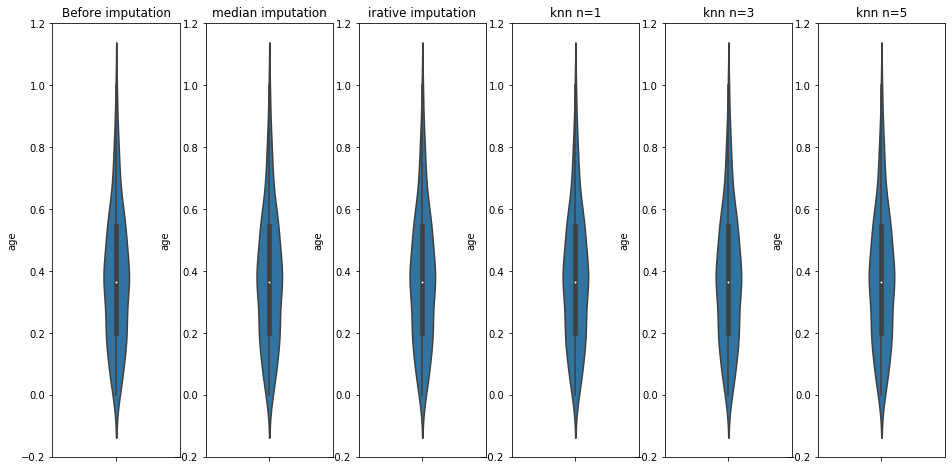

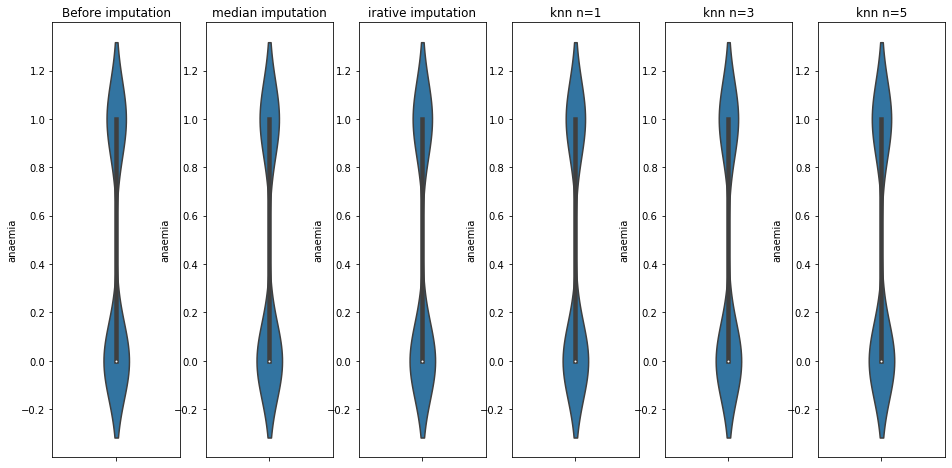

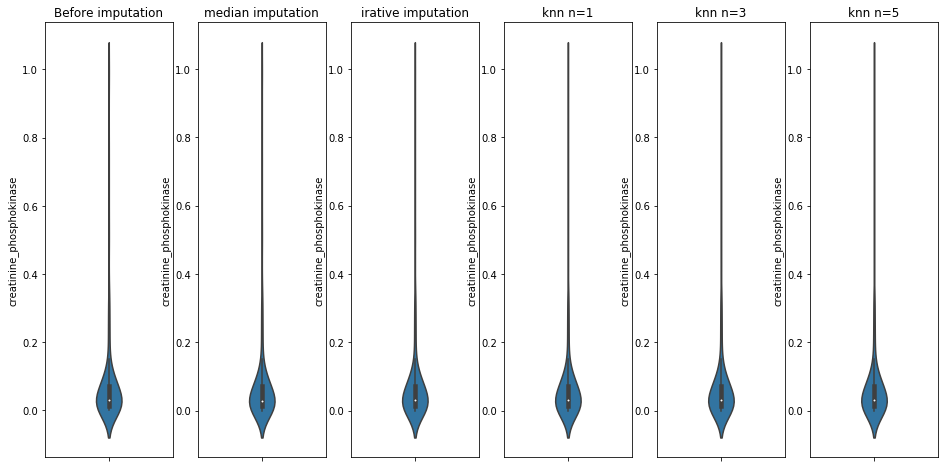

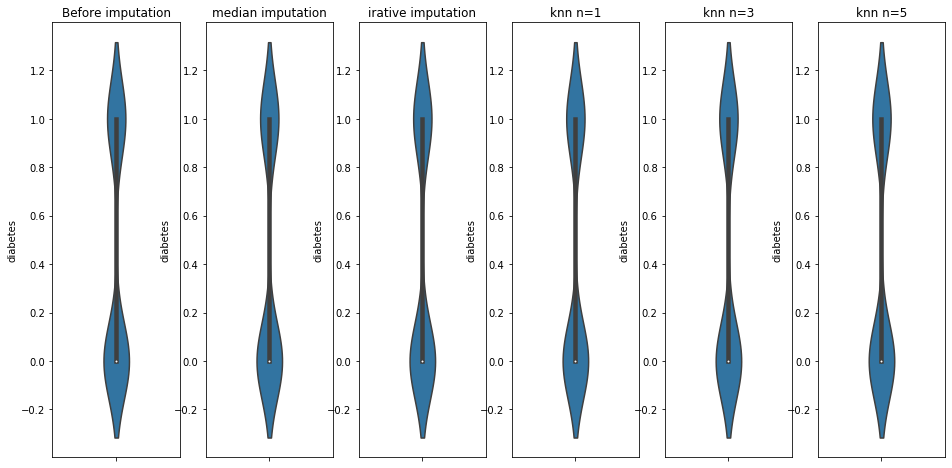

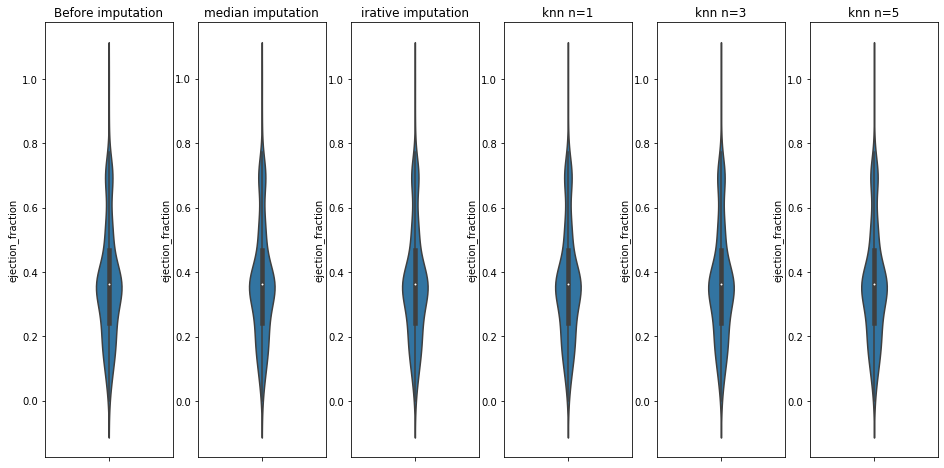

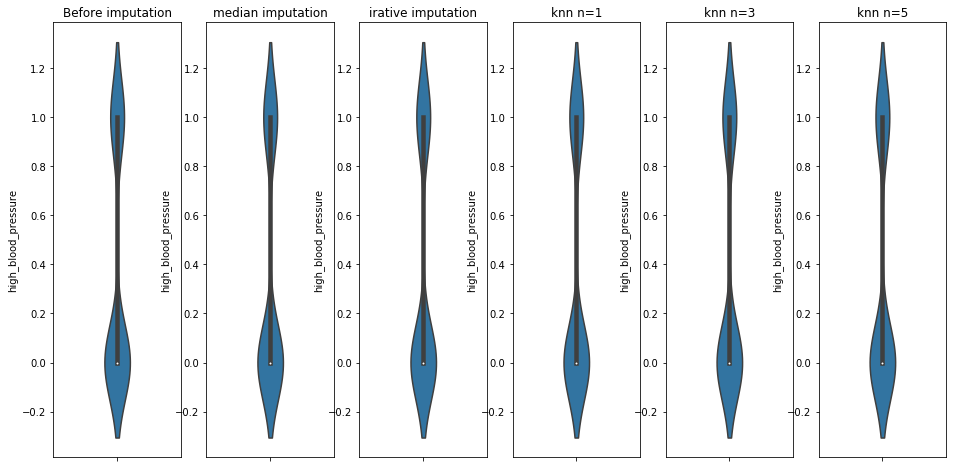

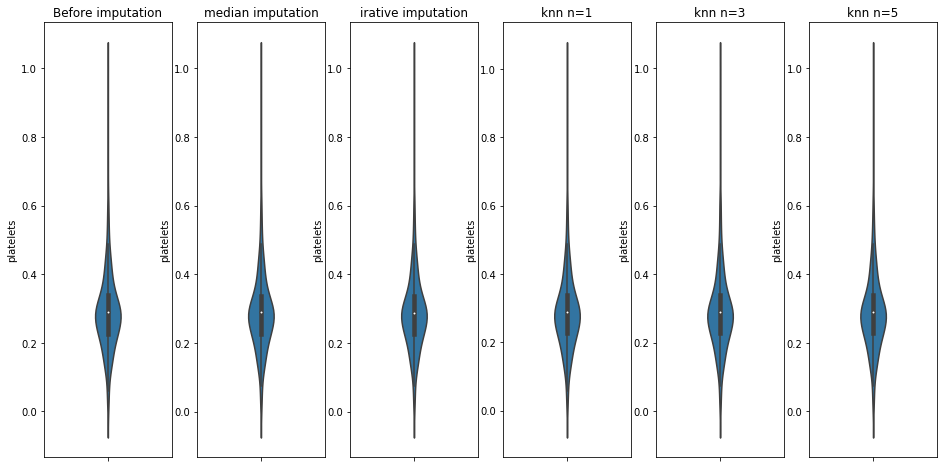

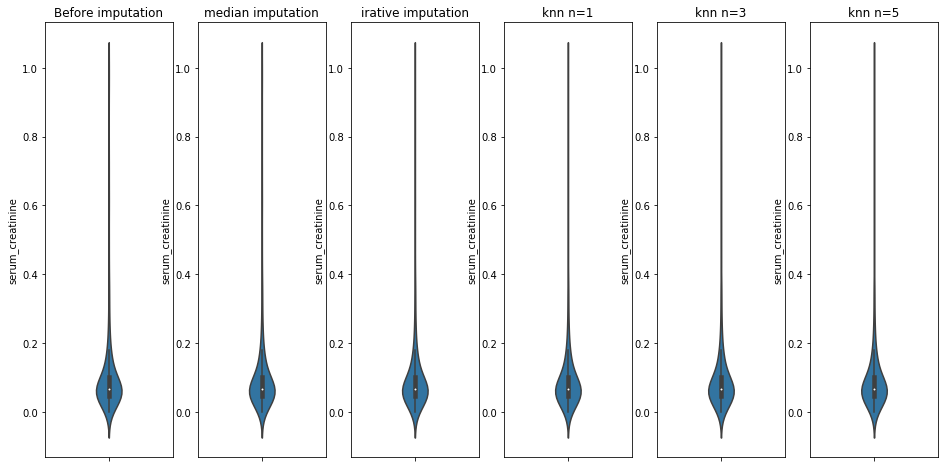

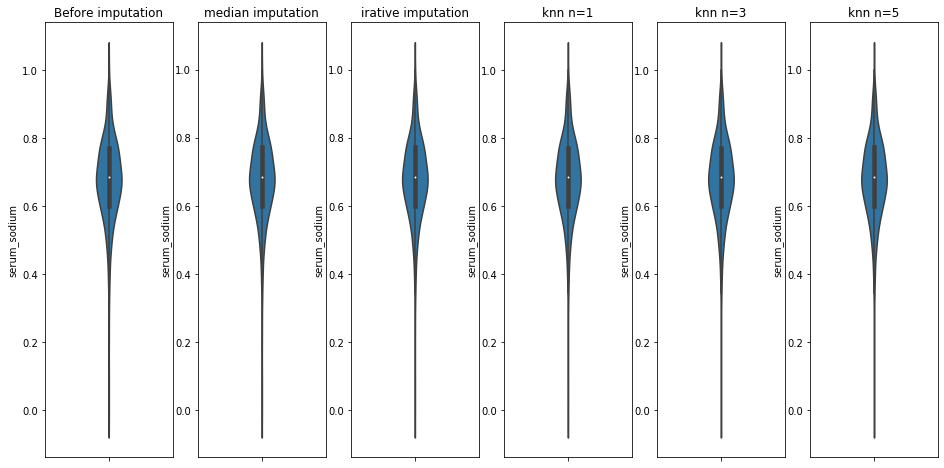

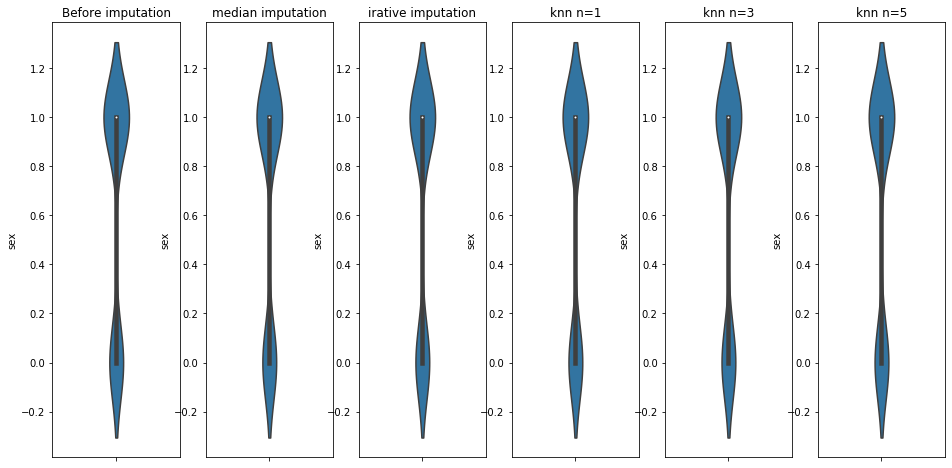

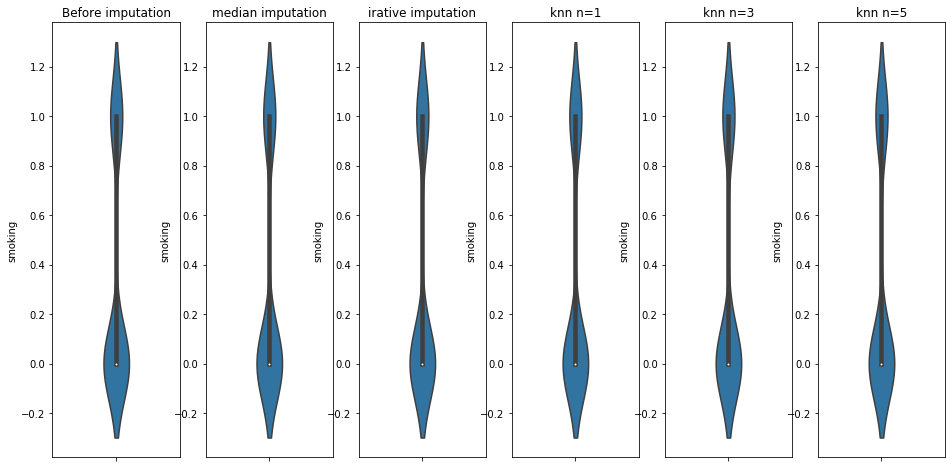

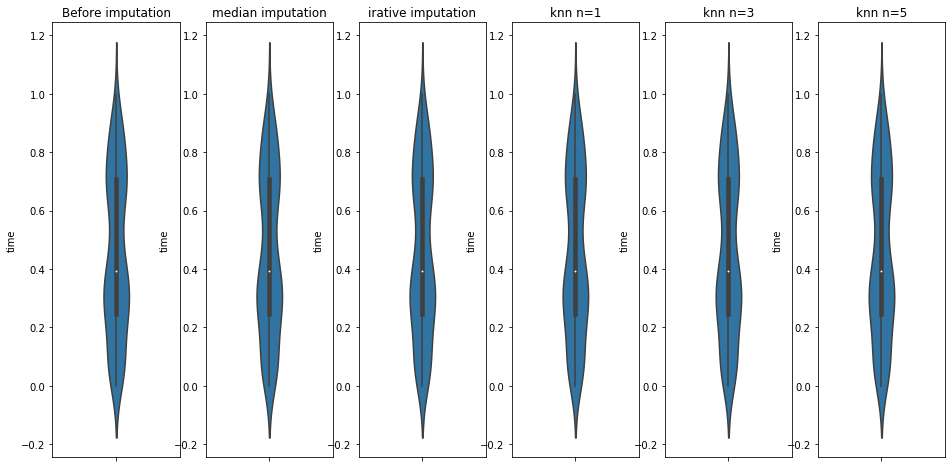

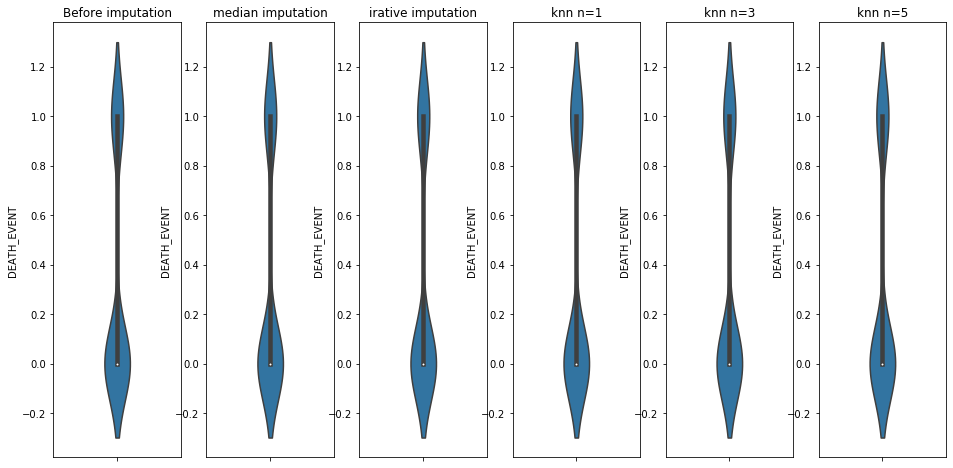

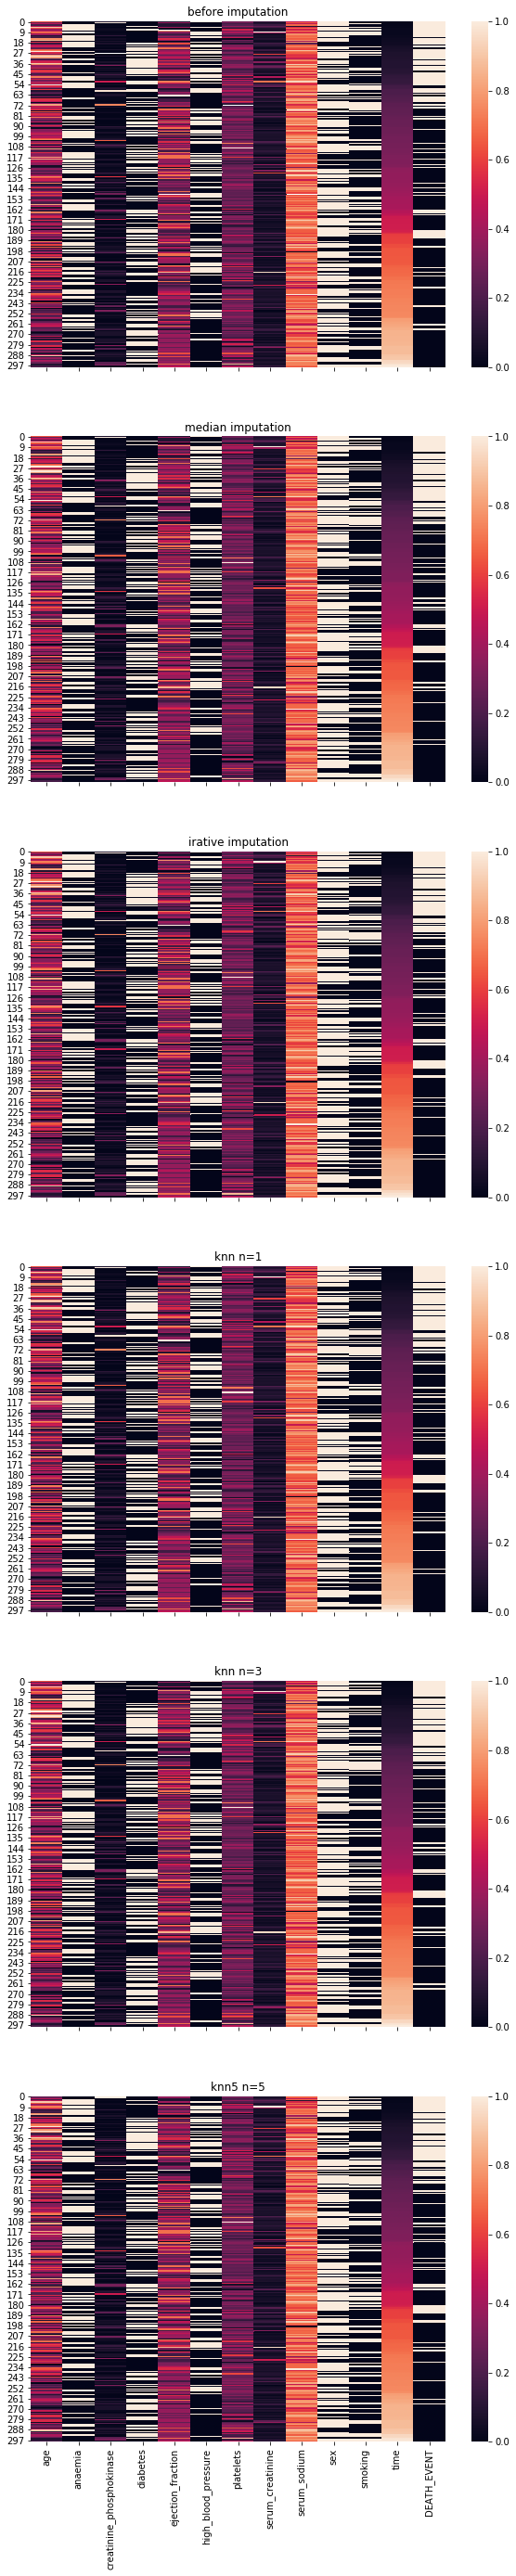

In [6]:
## visualization of imputation
# input: df_scaled_imp_median
#         df_scaled_imp_iterative
#         df_scaled_knn1
#         df_scaled_knn3
#         df_scaled_knn5
# output: df_scaled_imputed (set using results obtained)

# visiulization using violin plots
for column in df_scaled :
       fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(ncols=6,figsize=(16,8))
       sns.violinplot(y=df_scaled[column],width= 0.2, ax=ax1).set_title("Before imputation")
       sns.violinplot(y=df_scaled_imp_median[column],width= 0.2, ax=ax2).set_title("median imputation")
       sns.violinplot(y=df_scaled_imp_iterative[column],width= 0.2, ax=ax3).set_title("irative imputation")
       sns.violinplot(y=df_scaled_knn1[column],width= 0.2, ax=ax4).set_title("knn n=1")
       sns.violinplot(y=df_scaled_knn3[column],width= 0.2, ax=ax5).set_title("knn n=3")
       sns.violinplot(y=df_scaled_knn5[column],width= 0.2, ax=ax6).set_title("knn n=5")
        
#heatmaps
fig,(ax1, ax2, ax3, ax4, ax5, ax6)= plt.subplots(nrows=6,figsize=(10,48),sharex=True)
sns.heatmap(df_scaled,ax=ax1).set_title("before imputation")
sns.heatmap(df_scaled_imp_median,ax=ax2).set_title("median imputation")
sns.heatmap(df_scaled_imp_iterative,ax=ax3).set_title("irative imputation")
sns.heatmap(df_scaled_knn1,ax=ax4).set_title("knn n=1")
sns.heatmap(df_scaled_knn3,ax=ax5).set_title("knn n=3")
sns.heatmap(df_scaled_knn5,ax=ax6).set_title("knn5 n=5")

# based on the results an imputation method is set here 
df_scaled_imputed = df_scaled_knn3

PCA

[0.38449333 0.20061315 0.14933171 0.07981441 0.06837864 0.06504686
 0.0523219 ]
1.0


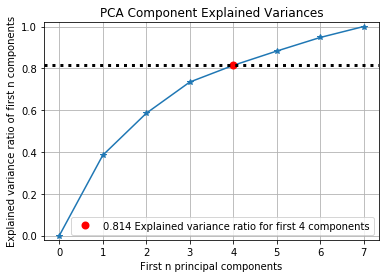

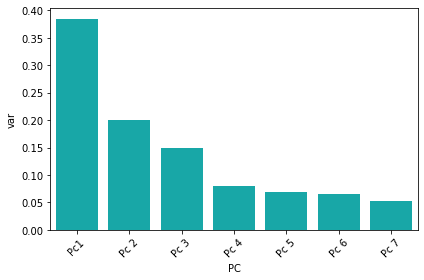

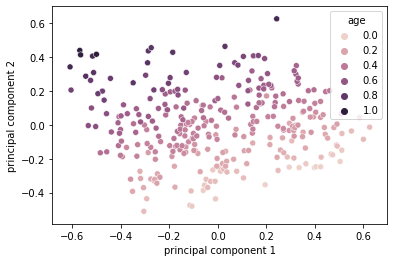

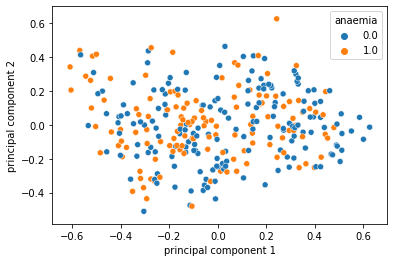

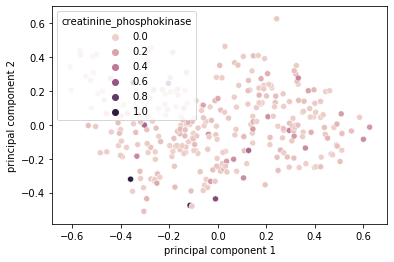

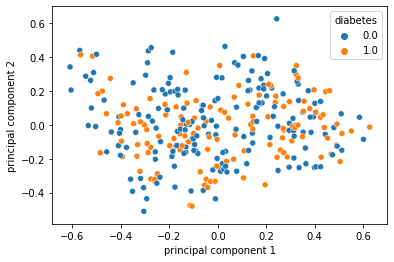

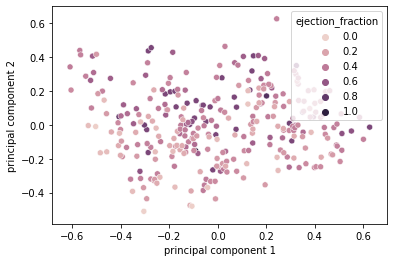

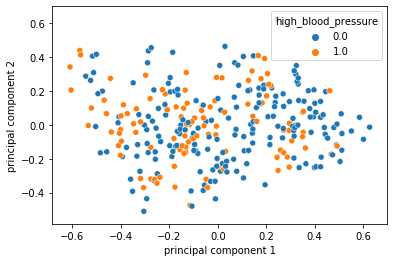

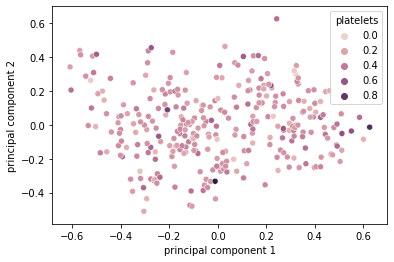

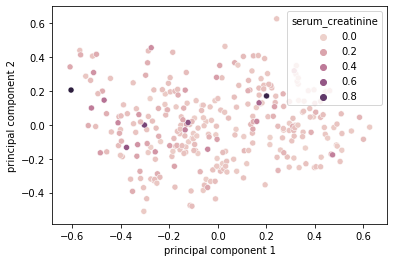

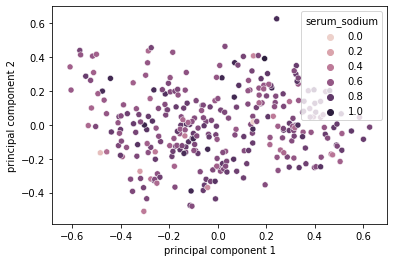

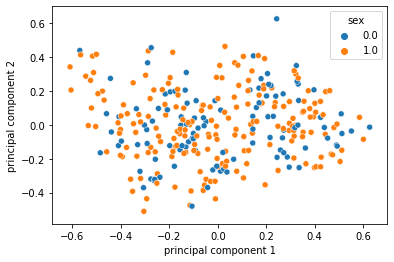

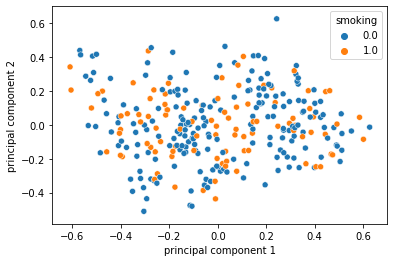

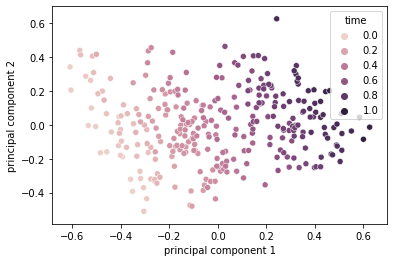

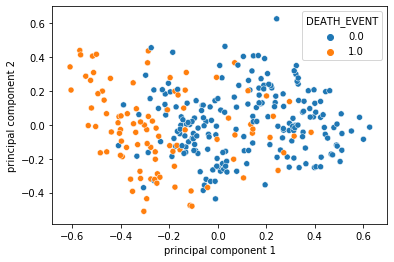

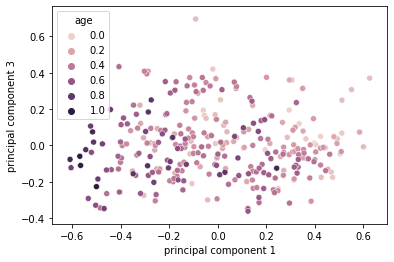

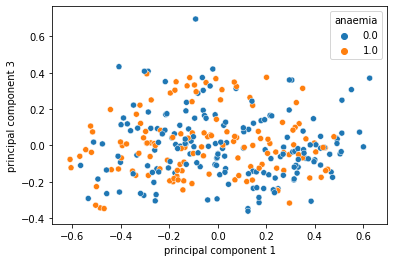

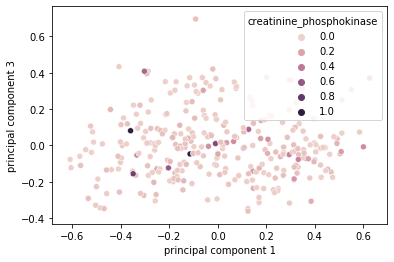

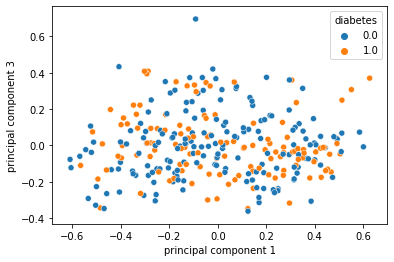

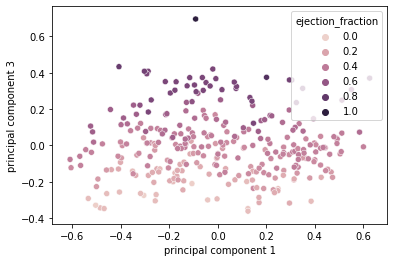

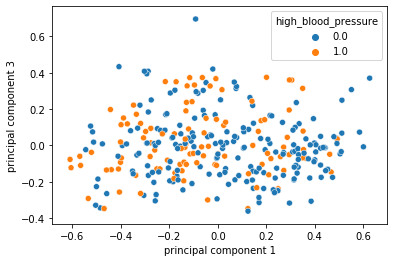

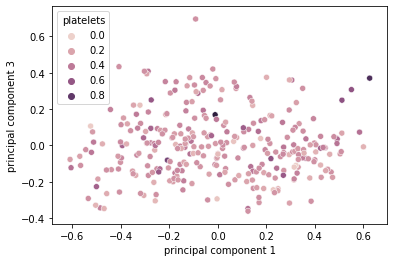

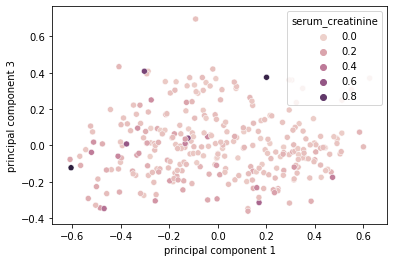

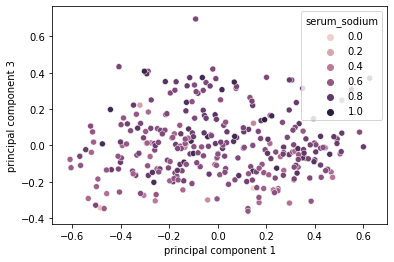

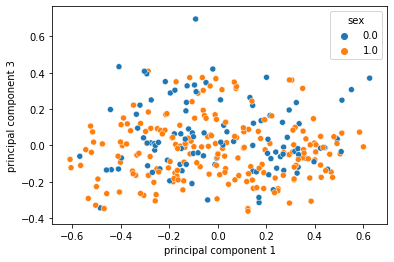

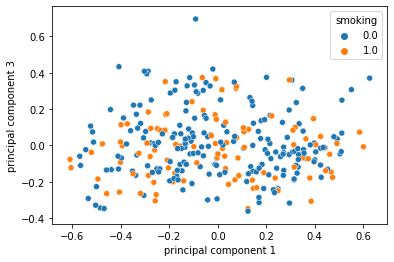

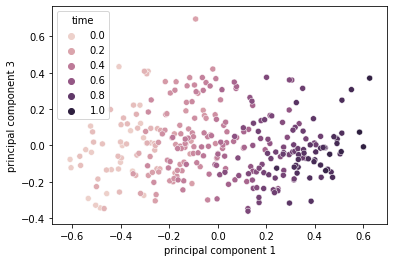

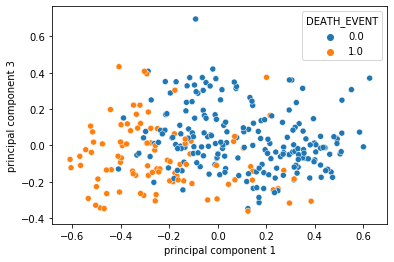

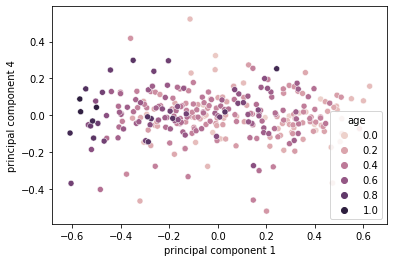

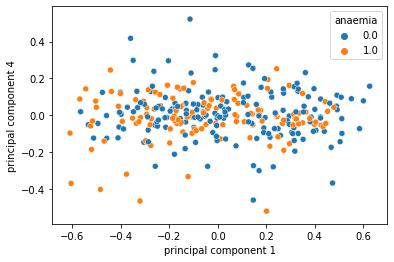

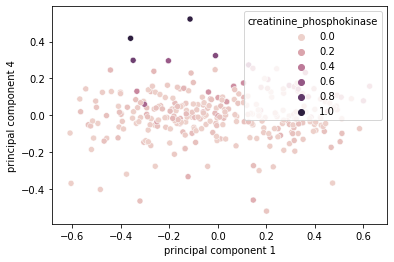

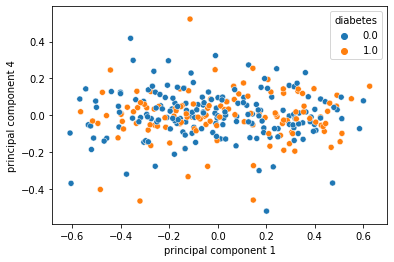

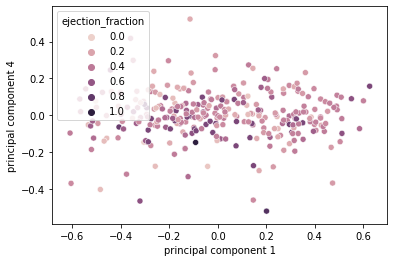

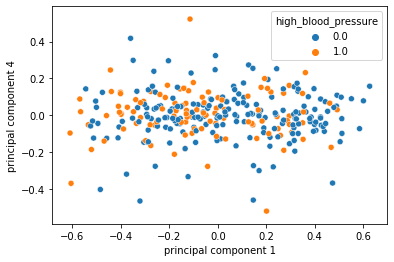

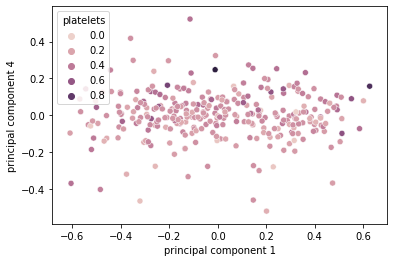

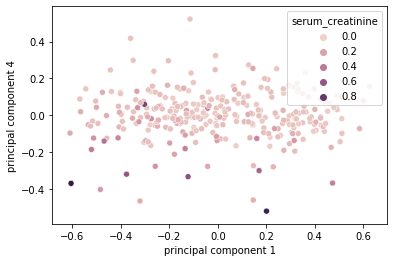

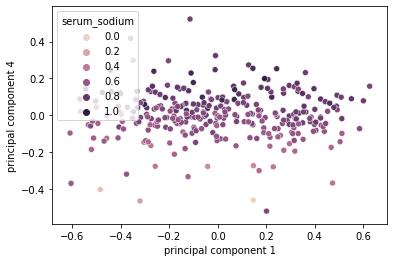

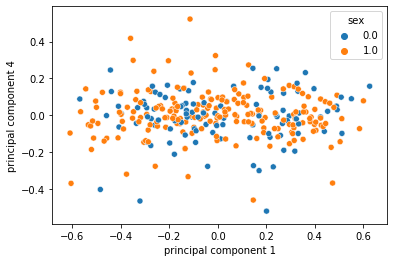

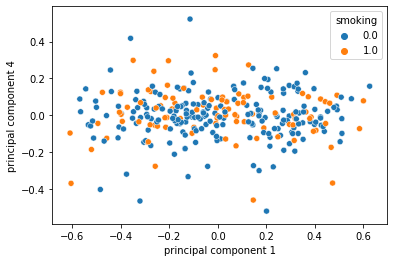

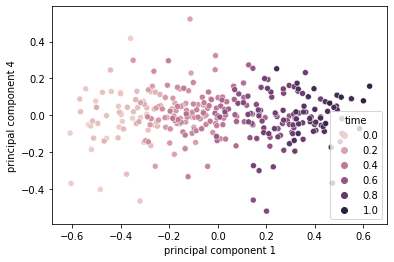

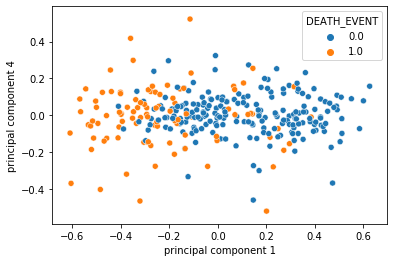

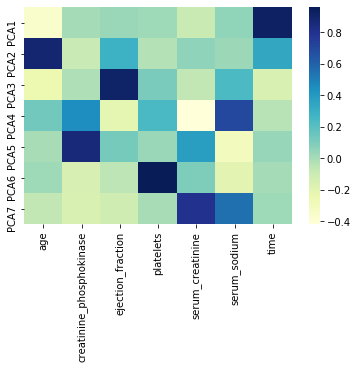

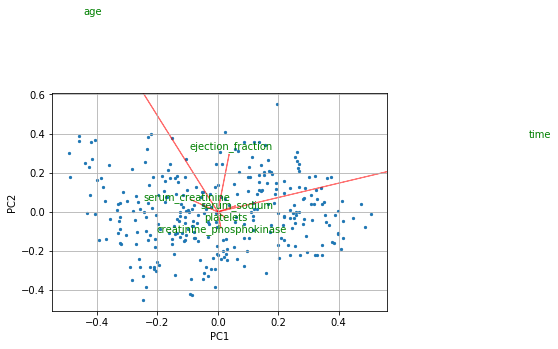

In [7]:
## PCA 

# note to self only do the pca on the contineuos data
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# subset continous data for pca

df_pca = df_scaled_imputed[['age',
                           'creatinine_phosphokinase',
                           'ejection_fraction',
                           'platelets',
                           'serum_creatinine',
                           'serum_sodium',
                           'time']]

# PCA function for later use

def pca_function(continous_data,whole_data):
    pca = PCA(n_components=7,svd_solver='full')

    principalComponents = pca.fit_transform(continous_data)
    principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 
                          'principal component 2',
                          'principal component 3',
                          'principal component 4',
                          'principal component 5',
                          'principal component 6',
                          'principal component 7'])
                          

    print(pca.explained_variance_ratio_)
    print(sum(pca.explained_variance_ratio_))

    df_PCA_fitted = pd.concat([principalDf, whole_data], axis = 1)
    
    #variance plot
    import scikitplot as skplt
    skplt.decomposition.plot_pca_component_variance(pca)
    plt.show()



    #scree plot
    Scree_Points = pd.DataFrame({'var':pca.explained_variance_ratio_,
                 'PC':['Pc1',
                       'Pc 2',
                       'Pc 3',
                       'Pc 4',
                       'Pc 5',
                       'Pc 6',
                       'Pc 7']})

    plt.figure()
    sns.barplot(data=Scree_Points, x='PC',y="var", color="c");
    plt.xticks(rotation=45)
    plt.tight_layout()

    
    #visualization for PC1,PC2, and PC4
    for column in whole_data :
        plt.figure()
        sns.scatterplot(data=df_PCA_fitted,x="principal component 1", y="principal component 2", hue=column)
    for column in whole_data :
        plt.figure()
        sns.scatterplot(data=df_PCA_fitted,x="principal component 1", y="principal component 3", hue=column)
    for column in whole_data :
        plt.figure()
        sns.scatterplot(data=df_PCA_fitted,x="principal component 1", y="principal component 4", hue=column)
    plt.show()
    
    # heatmap for variance explained by continouis variable
    ax = sns.heatmap(pca.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(x) for x in range(1,pca.n_components_+1)],
                 xticklabels=list(continous_data.columns))
    plt.show()
    
    # biplot
    def biplot(score,coeff,labels=None):
        #biplot function 
        xs = score[:,0]
        ys = score[:,1]
        n = coeff.shape[0]
        scalex = 1.0/(xs.max() - xs.min())
        scaley = 1.0/(ys.max() - ys.min())
        plt.scatter(xs * scalex,ys * scaley,s=5)
        for i in range(n):
            plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
            if labels is None:
                plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
            else:
                plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
        plt.xlabel("PC{}".format(1))
        plt.ylabel("PC{}".format(2))
        plt.grid()

    biplot(principalComponents[:,0:2],np.transpose(pca.components_[0:2, :]),list(continous_data.columns))
    plt.show()

    
# 3d plot 
def plot_3d(pc1,pc2,pc3):
    # Configure Plotly to be rendered inline in the notebook.
    plotly.offline.init_notebook_mode()

    # Configure the trace.
    trace = go.Scatter3d(
        x=pc1,  # <-- Put your data instead
        y=pc2,  # <-- Put your data instead
        z=pc3,  # <-- Put your data instead
        mode='markers',
        marker={
            'size': 2,
            'opacity': 0.8,
        }
    )

    # Configure the layout.
    layout = go.Layout(
        margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
           
    )

    data = [trace]

    plot_figure = go.Figure(data=data, layout=layout)

    # Render the plot.
    plotly.offline.iplot(plot_figure)


    
    
    
pca_function(df_pca,df_scaled_imputed)
# plot_3d(df_PCA_fitted["principal component 1"],df_PCA_fitted["principal component 2"],df_PCA_fitted["principal component 3"])










Outliers were detected using undirected random forest (isolation forest) 

total amount of outliers: 15
index location: [4, 5, 9, 19, 37, 52, 60, 72, 105, 117, 163, 187, 199, 217, 296]
MinMaxScaler()
total samples after removal of outliers: 284
total death events with outliers: 96.0
total death event without outliers: 84.0
percentage death event with outliers: 32.10702341137124 %
percentage death event without outliers: 29.577464788732392 %


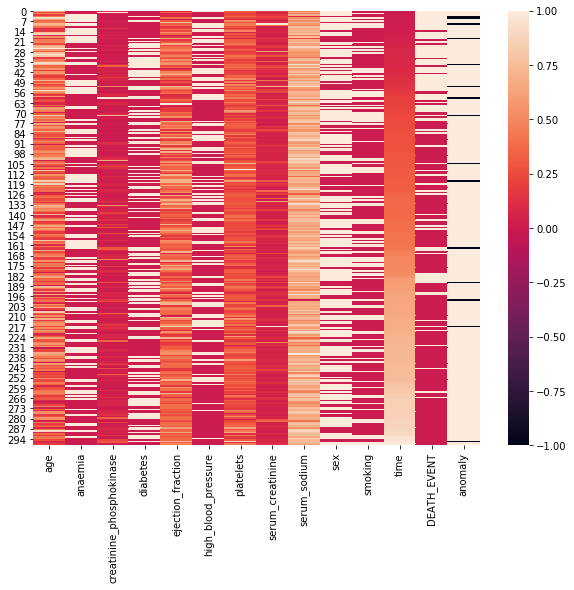

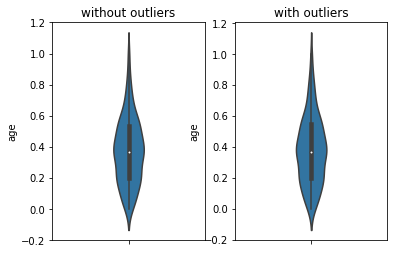

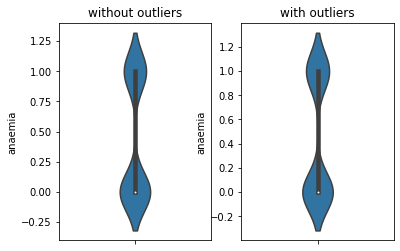

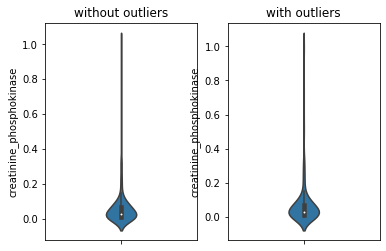

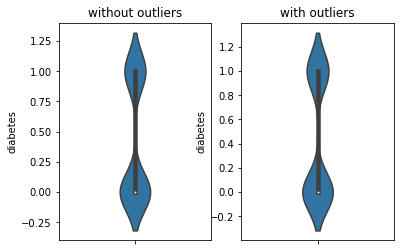

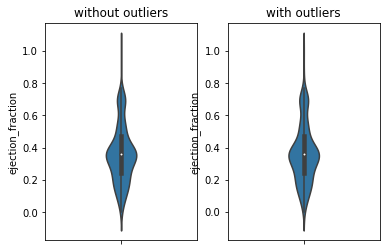

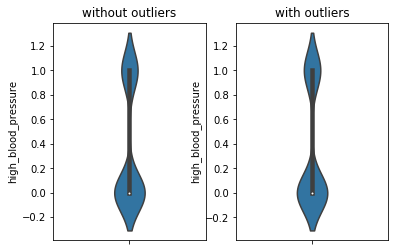

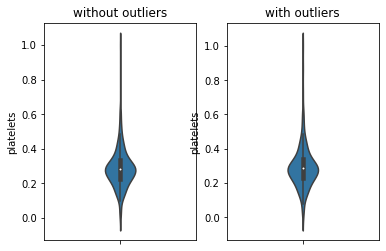

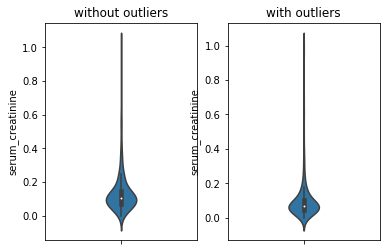

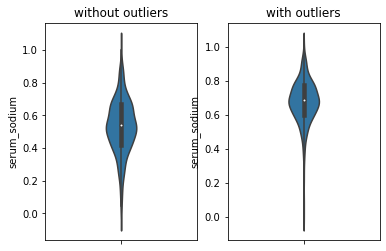

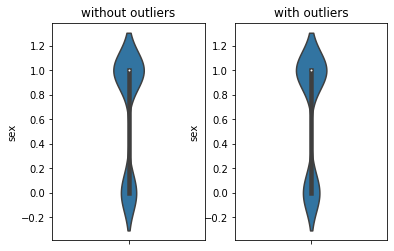

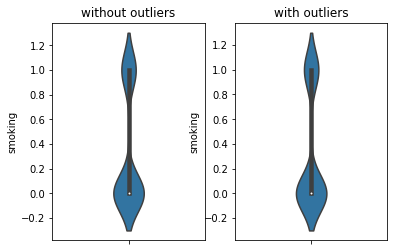

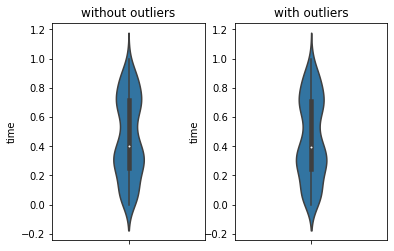

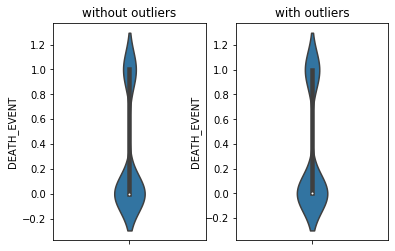

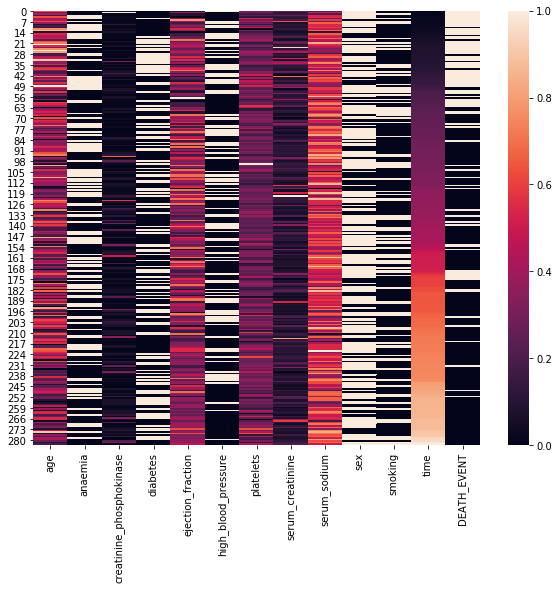

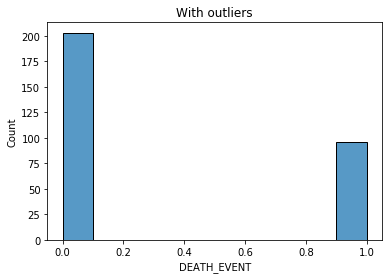

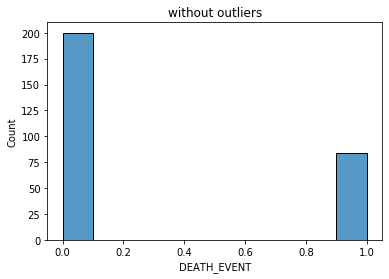

In [8]:
## outlier detection using isolation forest
# input: df_scaled_imputed
# output: df_scaled_imputed_wo_outliers
#         anomaly
#         anomaly_index
#         df_scaled_imputed_anomaly

# outlier detection using isolation forest 
outliers_fraction = 0.05

#prep anomoly detection
df_scaled_imputed_anomaly = df_scaled_imputed

URF=IsolationForest(n_estimators=100, max_samples='auto',random_state=42,contamination=outliers_fraction)
URF.fit(df_scaled_imputed)

#df_scaled_imputed['scores']=URF.decision_function(df_scaled_imputed)
df_scaled_imputed_anomaly['anomaly']=URF.predict(df_scaled_imputed)
df_scaled_imputed_anomaly.head(20)

anomaly = df_scaled_imputed_anomaly.loc[df_scaled_imputed['anomaly']==-1]
anomaly_index = list(anomaly.index)

print('total amount of outliers:',len(anomaly_index))
print('index location:',anomaly_index)


# heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df_scaled_imputed)




# dropping the 'Outliers' and rescaling
df_scaled_imputed_wo_outliers  = df_scaled_imputed
df_scaled_imputed_wo_outliers  = df_scaled_imputed_wo_outliers.drop(anomaly_index)
df_scaled_imputed_wo_outliers = df_scaled_imputed_wo_outliers.drop(['anomaly'], axis=1) #dropping column anomaly


scaler = MinMaxScaler()
print(scaler.fit(df_scaled_imputed_wo_outliers))


df_scaled_imputed_wo_outliers_temp = scaler.transform(df_scaled_imputed_wo_outliers)
df_scaled_imputed_wo_outliers = pd.DataFrame(data=df_scaled_imputed_wo_outliers_temp, columns=df.columns.tolist())

print('total samples after removal of outliers:',len(df_scaled_imputed_wo_outliers))


# visualization of outliers dropping
for column in df_scaled_imputed_wo_outliers :
       fig, (ax1, ax2) = plt.subplots(ncols=2)
       sns.violinplot(y=df_scaled_imputed_wo_outliers[column],width= 0.2, ax=ax1).set_title("without outliers")
       sns.violinplot(y=df_scaled_imputed[column],width= 0.2, ax=ax2).set_title("with outliers")
# heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df_scaled_imputed_wo_outliers)

#histplot for death events
plt.figure()
sns.histplot(data=df_scaled_imputed, x='DEATH_EVENT').set_title("With outliers")
plt.figure()
sns.histplot(data=df_scaled_imputed_wo_outliers, x='DEATH_EVENT').set_title("without outliers")

#death events statistics

total_death_event_w_outliers = df_scaled_imputed['DEATH_EVENT'].sum()
total_death_event_wo_outliers = df_scaled_imputed_wo_outliers['DEATH_EVENT'].sum()       
total_death_event_w_outliers_percentage =(total_death_event_w_outliers/len(df_scaled_imputed))*100
total_death_event_wo_outliers_percentage =(total_death_event_wo_outliers/len(df_scaled_imputed_wo_outliers))*100

print('total death events with outliers:',total_death_event_w_outliers)
print('total death event without outliers:',total_death_event_wo_outliers)
print('percentage death event with outliers:',total_death_event_w_outliers_percentage, '%')
print('percentage death event without outliers:',total_death_event_wo_outliers_percentage,'%')

Repeat of PCA analyis after 

[0.36871147 0.19422308 0.16534631 0.10567318 0.06537584 0.05478686
 0.04588326]
0.9999999999999999


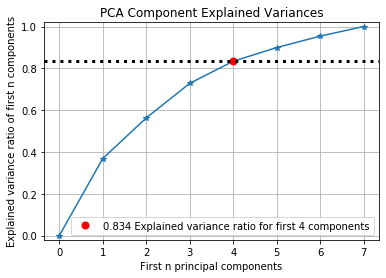

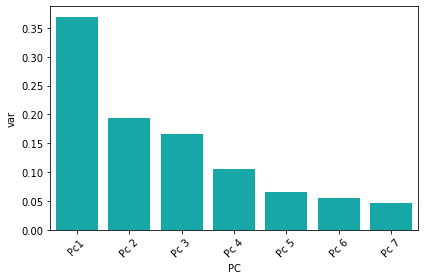

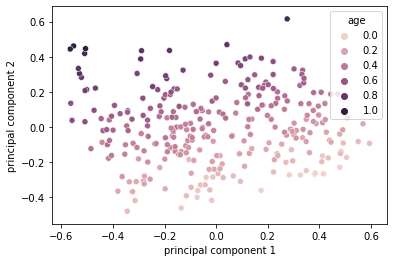

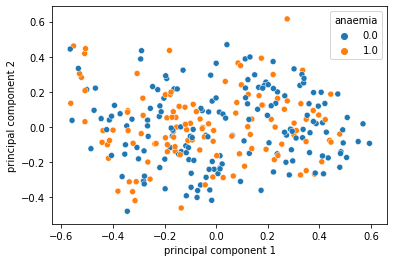

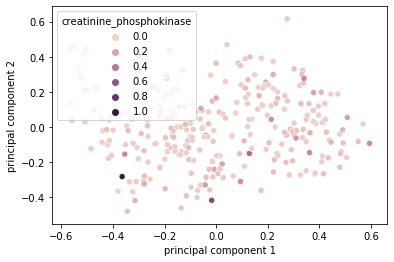

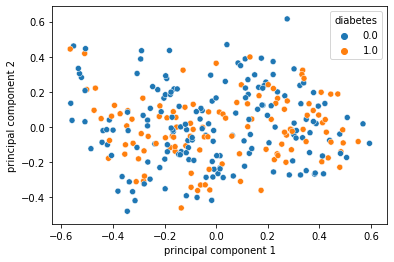

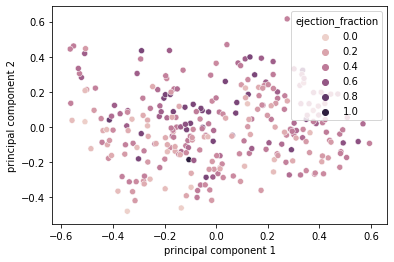

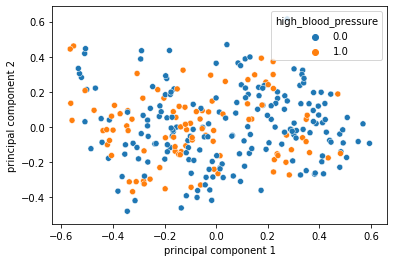

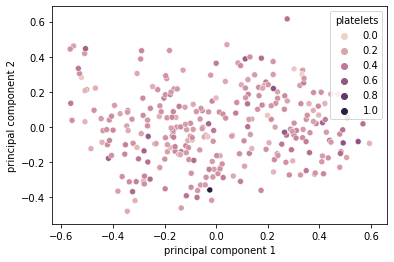

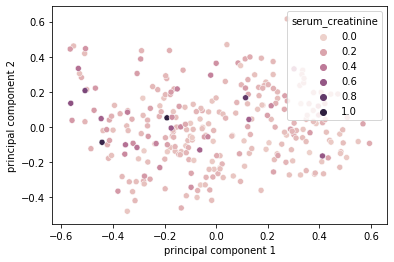

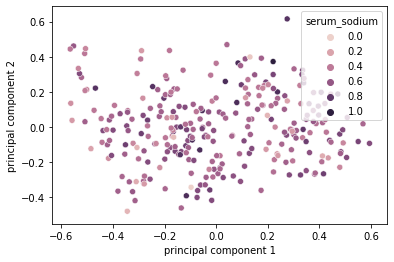

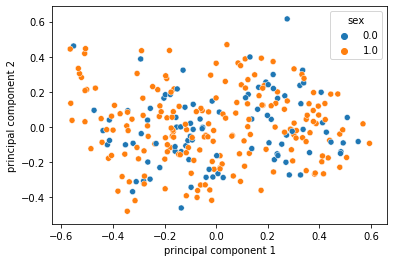

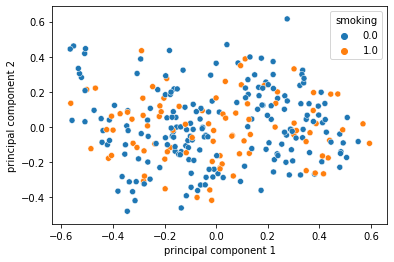

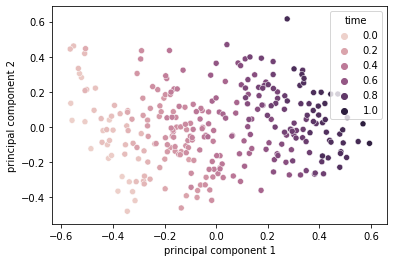

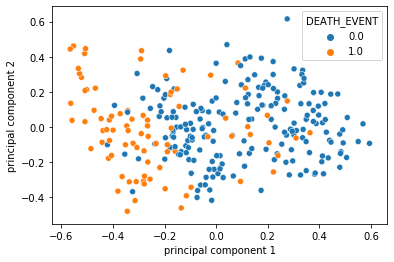

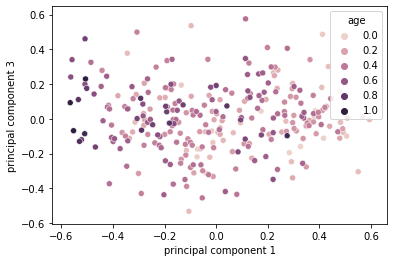

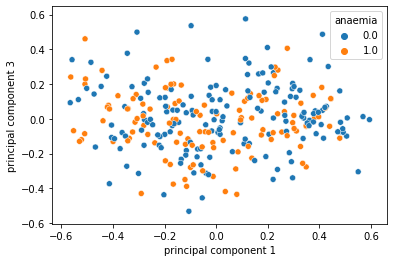

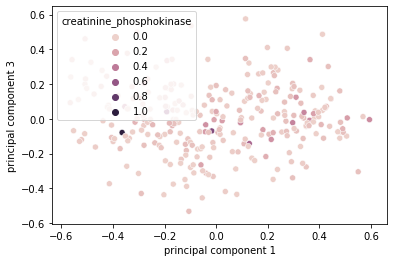

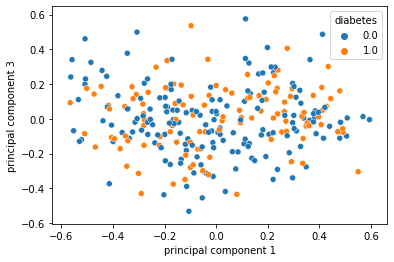

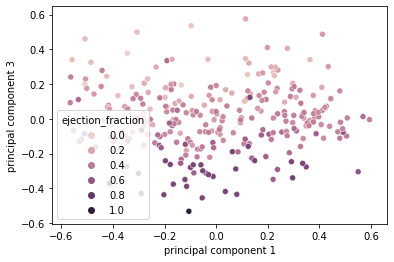

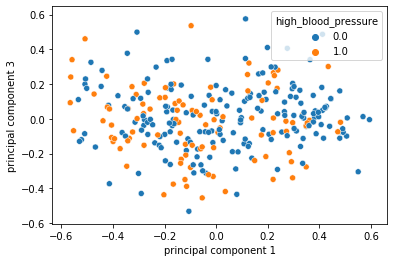

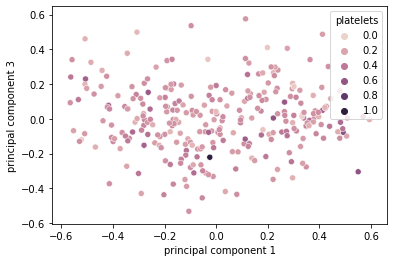

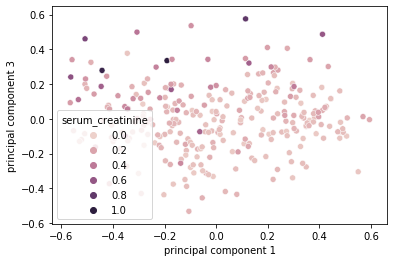

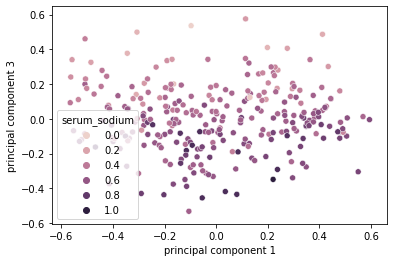

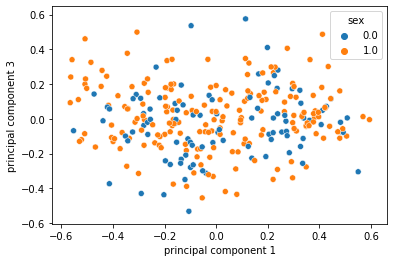

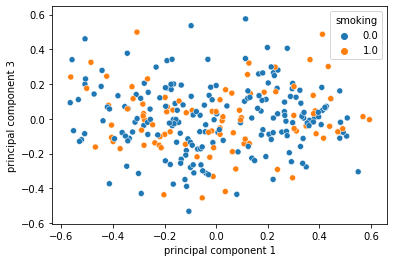

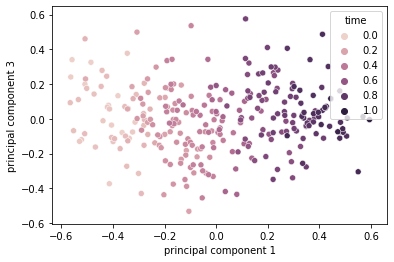

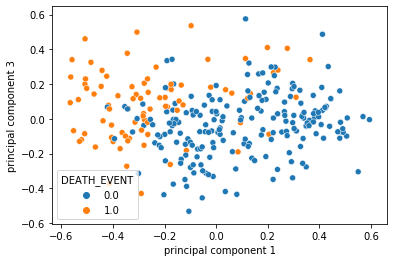

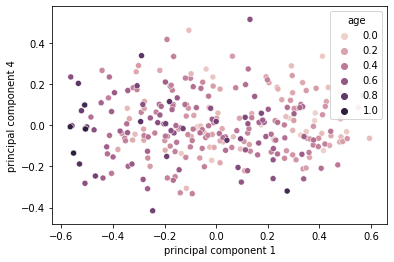

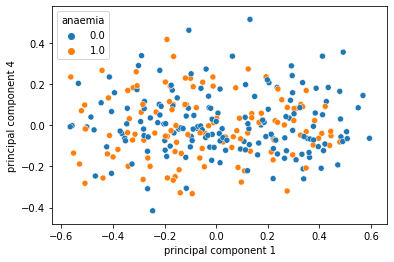

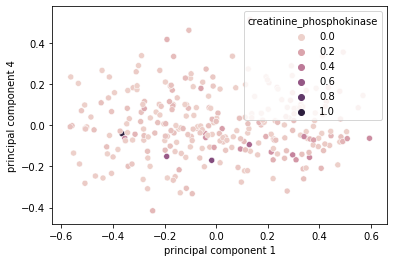

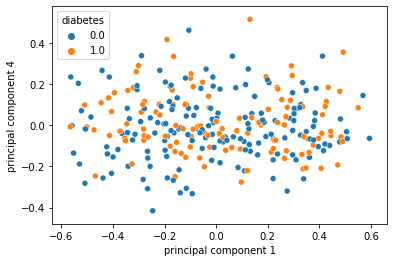

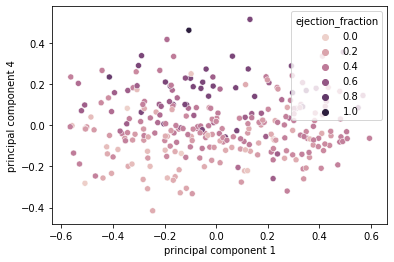

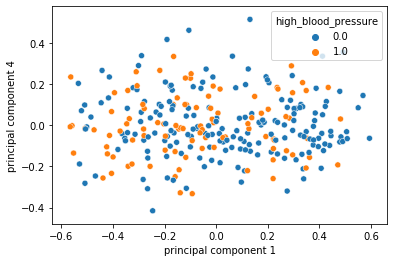

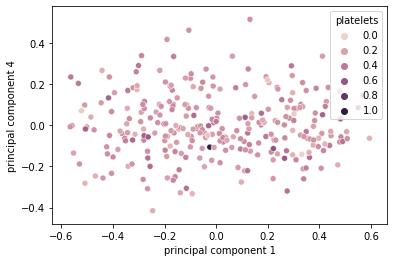

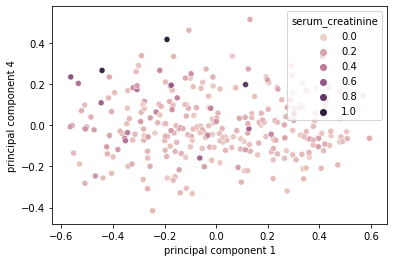

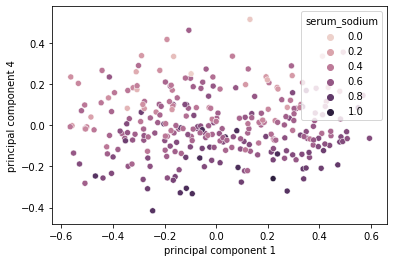

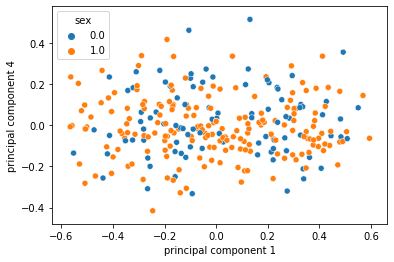

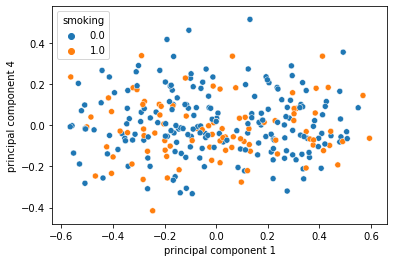

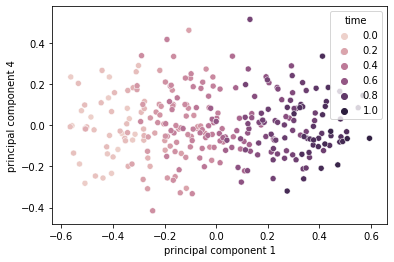

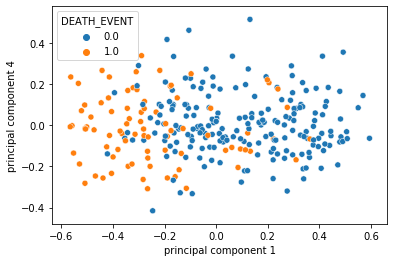

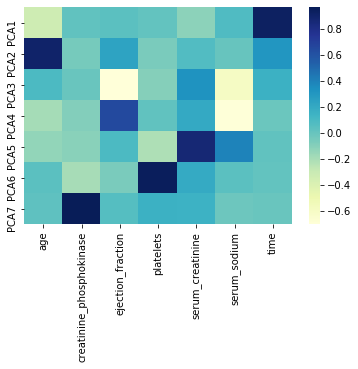

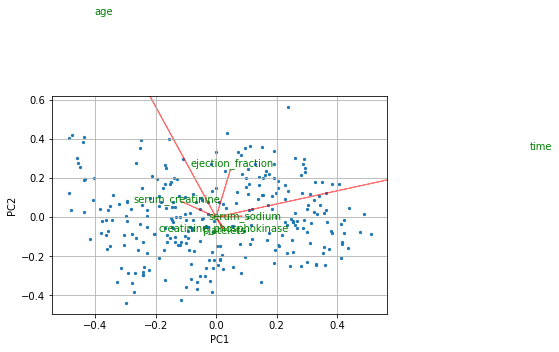

In [9]:
# subset continous data for pca
df_pca_2 = df_scaled_imputed_wo_outliers[['age',
                           'creatinine_phosphokinase',
                           'ejection_fraction',
                           'platelets',
                           'serum_creatinine',
                           'serum_sodium',
                           'time']]

pca_function(df_pca_2,df_scaled_imputed_wo_outliers)
#plot_3d(df_PCA_fitted["principal component 1"],df_PCA_fitted["principal component 2"],df_PCA_fitted["principal component 3"])







This result is rather strange as the the two biggest contributors to the effects is time and age. In order to further explore this correlation analysis is done for time and death and age and death. to see which correlates more to this event. This was done because it was believed that time is correlated with death based on the plots from the exploratorie analysis, and it would be logical that age would also correlate with the death event. this correlation analysis will be done using Point-Biserial Correlation Coefficient which can correlate between binary and continouse data. this test is based on the pearson correlation test.

In [10]:
## correlation analysis based on Point-Biserial Correlation Coefficient python Point-Biserial Correlation Coefficient 
#Input:
#Output:

from scipy import stats

biserial_correlation_time_death = stats.pointbiserialr(df_scaled_imputed_wo_outliers['DEATH_EVENT'],
                                                      df_scaled_imputed_wo_outliers['time'])
biserial_correlation_age_death = stats.pointbiserialr(df_scaled_imputed_wo_outliers['DEATH_EVENT'],
                                                      df_scaled_imputed_wo_outliers['age'])
biserial_correlation_ejection_fraction_death = stats.pointbiserialr(df_scaled_imputed_wo_outliers['DEATH_EVENT'],
                                                                      df_scaled_imputed_wo_outliers['ejection_fraction'])


print("time and death corr:", biserial_correlation_time_death)
print("age and death corr:", biserial_correlation_age_death)
print("ejection fraction and death corr:", biserial_correlation_ejection_fraction_death)

time and death corr: PointbiserialrResult(correlation=-0.5154624463902026, pvalue=1.1172344871044304e-20)
age and death corr: PointbiserialrResult(correlation=0.2520681213992754, pvalue=1.7171885804936832e-05)
ejection fraction and death corr: PointbiserialrResult(correlation=-0.3164896034710816, pvalue=5.014120584389607e-08)


### Classification
the data was split into 3 subsets a test set, a train set, and a holdout set (10% of the data). due to the inbalance in the data a stratified method was used

In [11]:
# laod in module train test split to make holdout set, and pca

from sklearn.model_selection import train_test_split
from pca import pca


# spliting of data into features and targets

target = df_scaled_imputed_wo_outliers['DEATH_EVENT']
features = df_scaled_imputed_wo_outliers.drop(['time', 'DEATH_EVENT'], axis = 1) 


# hold out set split

X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.1,
                                                    random_state=42)

# assigning names

holdout_features_test = X_test
holdout_target_test = y_test
features_after_holdout = X_train
target_after_holdout = y_train


# checking the sets

print('amount of patients in the classification set:',len(features_after_holdout))
print('amount of death events in holdout:',holdout_target_test.sum(), ',',holdout_target_test.sum()/len(holdout_target_test), '%' )
print('amount of death events in classification set:',target_after_holdout.sum(), ',',target_after_holdout.sum()/len(target_after_holdout), '%' )


print(features_after_holdout.head())






amount of patients in the classification set: 255
amount of death events in holdout: 11.0 , 0.3793103448275862 %
amount of death events in classification set: 73.0 , 0.28627450980392155 %
          age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
108  0.454545      1.0                  0.011483       1.0           0.696970   
247  0.400000      1.0                  0.080633       0.0           0.393939   
158  0.545455      0.0                  0.103598       0.0           0.318182   
167  0.418182      1.0                  0.012631       1.0           0.696970   
45   0.509091      1.0                  0.070681       0.0           0.166667   

     high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
108                  1.0   0.215663          0.071429      0.666667  0.0   
247                  0.0   0.312644          0.035714      0.375000  0.0   
158                  1.0   0.339314          0.053571      0.375000  0.0   
167                  

In [18]:
# creating train and validation set using oversampeling with bootstrap.
# input
# output

#importing packages
import imblearn
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_sample(features_after_holdout, target_after_holdout)


# splitting overbalanced sets into train and test set. with a split of 80/20
features_train, features_test, target_train, target_test = train_test_split(X_ros,
                                                                            y_ros,
                                                                            test_size=0.2,
                                                                            random_state=42)


In [73]:
from sklearn.svm import SVC
from sklearn import svm

clf_SVM = svm.SVC(C=2,
                  kernel = 'rbf',
                  gamma='scale',
                  class_weight = 'balanced',
                  random_state = 42)

clf_SVM = clf_SVM.fit(features_train, target_train)

test_predict_svm = clf_SVM.predict(features_test)

Average precision-recall score: 0.70


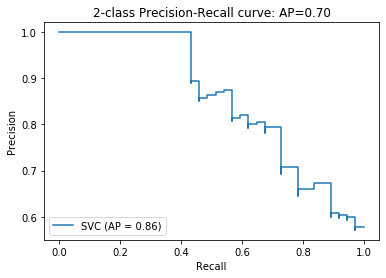

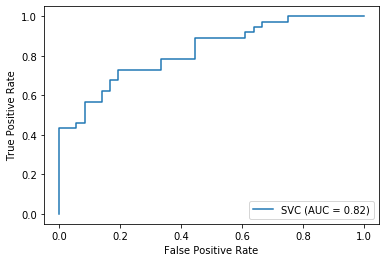

In [76]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve

average_precision = average_precision_score(target_test, test_predict_svm)
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))



disp = plot_precision_recall_curve(clf_SVM, features_test, target_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))


plot_roc_curve(clf_SVM,features_test, target_test)